
# Fruit Inspection
*Eleonora Misino - Feb. 12, 2020*

----------------------------------
We analyzeto analyze some fruits to find out their imperfections.
The 

1. **Load Images**
2. **Fruit Segmentation**  
    2.1 Otsu's Method  
    2.2 Flood-fill Approach  
    2.3 Segmented Images
3. **Defects Detection**  
    3.1 Canny Edge Detector  
    3.2 Erosion  
4. **Conclusion**

## 1. Load Images
We have 3 pairs of images acquired through a NIR (Near Infra-Red) and a color camera with little parallax effect.  
We load and display them below.

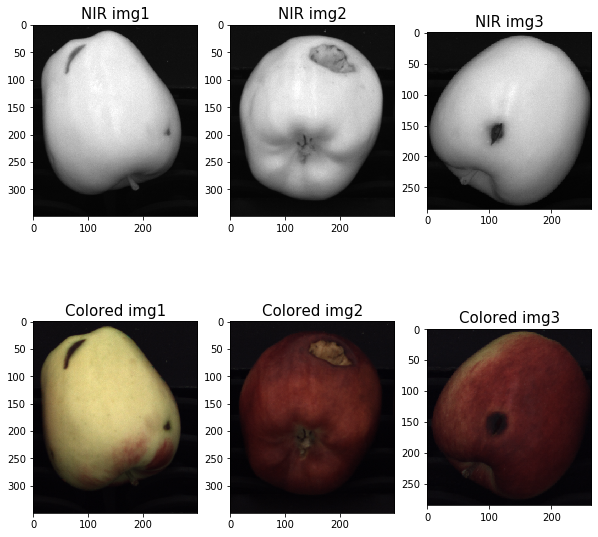

In [6]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#NIR images
img1 = cv2.imread("first task/C0_000001.png", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("first task/C0_000002.png", cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread("first task/C0_000003.png", cv2.IMREAD_GRAYSCALE)


#Colored images
img1_c = cv2.cvtColor(cv2.imread("first task/C1_000001.png", cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB) 
img2_c = cv2.cvtColor(cv2.imread("first task/C1_000002.png", cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB) 
img3_c = cv2.cvtColor(cv2.imread("first task/C1_000003.png", cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB) 

#Plot images
plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(img1, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.subplot(2,3,2)
plt.imshow(img2, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img2", fontsize = 15)
plt.subplot(2,3,3)
plt.imshow(img3, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img3", fontsize = 15)
plt.subplot(2,3,4)
plt.imshow(img1_c)
plt.title("Colored img1", fontsize = 15)
plt.subplot(2,3,5)
plt.imshow(img2_c)
plt.title("Colored img2", fontsize = 15)
plt.subplot(2,3,6)
plt.imshow(img3_c)
plt.title("Colored img3", fontsize = 15)
plt.show()


## 2. Fruit Segmentation

We want to inspect the fruit to locate any defects, thus we need to remove the background and focus the analysis on the fruit (hereinafter called *foreground*). 

One of the most used tool to isolate the foreground is the so called ***Binary Mask***: a binary image having the same size as the target image and defining a region of interest (*ROI*).  
In particular: 
* mask pixel values of `1` indicate the image pixel belongs to the ROI;
* mask pixel values of `0` indicate the image pixel is part of the background.

We create our binary masks by **thresholding** the *gray-level histogram* of each NIR image displayed below.   

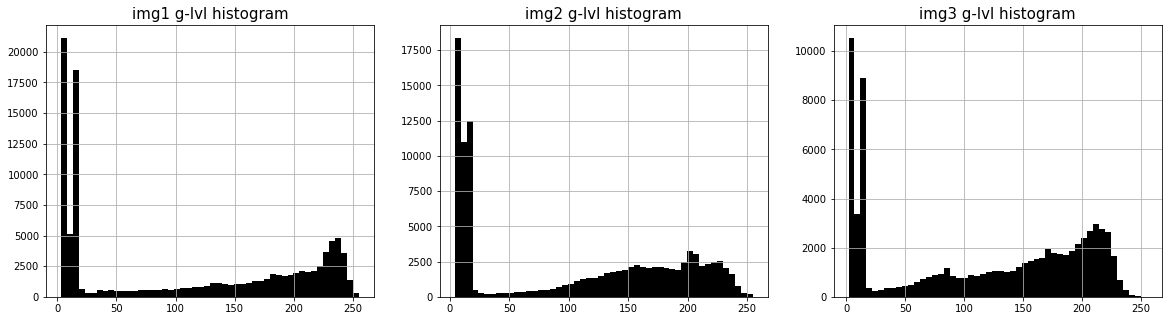

In [7]:
#Gray-level histograms
plt.figure(figsize = (20, 5), num = 'Gray-level histograms')
plt.subplot(1,3,1)
plt.hist(img1.flatten(), bins = 50, color = 'black');
plt.ticklabel_format()
plt.grid()
plt.title("img1 g-lvl histogram", fontsize = 15)
plt.subplot(1,3,2)
plt.hist(img2.flatten(), bins = 50, color = 'black');
plt.grid()
plt.title("img2 g-lvl histogram", fontsize = 15)
plt.subplot(1,3,3)
plt.hist(img3.flatten(), bins = 50, color = 'black');
plt.grid()
plt.title("img3 g-lvl histogram", fontsize = 15)
plt.show()

### 2.1  Otsu's Method

The three histograms clearly show the *background peaks*, but the gray-level values are spread over the whole range; thus it's **hard to manually find a correct threshold** for each image.    

How could we select a **meaningful threshold**?

One of the most well known approach is the [**Otsu's method**](https://en.wikipedia.org/wiki/Otsu%27s_method), which consists in maximizing the *between-group variance* of the background and the foreground.     
Therefore, this method provides the **thresholding value** which makes both the background and the foreground the **most homogeneous as possible**.


Once we have found the best threshold according to Otsu's method, we create our binary mask by setting at `0`  each pixel classified as background and at `1` each foreground pixel. 

The resulting masks exhibit some **holes** which coincide to the darkest regions of the fruit that have been **wrongly classified as background**.      
It's not surprising that the thresholding operation misclassified some pixels: as we highlighted, the intensity distribution is quite stretched and therefore the presence of *false negatives* and *false positives* is very likely. 

In [9]:
# Thresholding with Otsu's method
thresh = 25
maxValue = 1 
 
th1, dst1 = cv2.threshold(img1, thresh, maxValue, cv2.THRESH_OTSU)
th2, dst2 = cv2.threshold(img2, thresh, maxValue, cv2.THRESH_OTSU)
th3, dst3 = cv2.threshold(img3, thresh, maxValue, cv2.THRESH_OTSU);

In [11]:
print("The resulting thresholding values are:\n\n {:0.0f} for img1,\n {:0.0f} for img2,\n {:0.0f} for img3."\
      .format(th1, th2, th3))

The resulting thresholding values are:

 109 for img1,
 98 for img2,
 104 for img3.


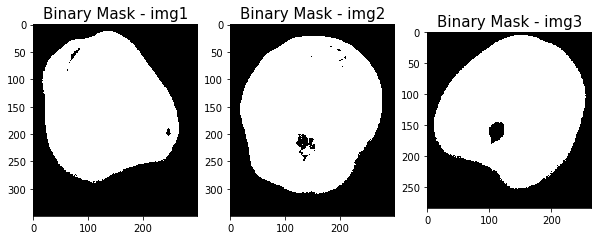

In [10]:
#Plot Binary Masks
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(dst1 * 255, cmap='gray', vmin=0, vmax=255)
plt.title("Binary Mask - img1", fontsize = 15)
plt.subplot(1,3,2)
plt.imshow(dst2 * 255, cmap='gray', vmin=0, vmax=255)
plt.title("Binary Mask - img2", fontsize = 15)
plt.subplot(1,3,3)
plt.imshow(dst3 * 255, cmap='gray', vmin=0, vmax=255)
plt.title("Binary Mask - img3", fontsize = 15)
plt.show()

### 2.2 Flood-fill approach
To correct the false negatives introduced by the thresholding, we use the [**flood-fill algorithm**](https://en.wikipedia.org/wiki/Flood_fill) to **fill the *connected components*** in the target image with a specified value.


In the lines below, we use the `floodFill` function of `OpenCV` to fill the holes inside our binary masks:
* we set at `1` the filling value and we prepare a $(h+2) \times (w+2)$ empty mask, where $h$ and $w$ are the dimensions of the original image;
* we fill the connected components in the original image and we invert the resulting binary image;
* we combine the original image with the new one to get a Binary Mask without holes. 

In [13]:
#Flood fill apporach

#Copy the masks
dst1_floodfill = dst1.copy()
dst2_floodfill = dst2.copy()
dst3_floodfill = dst3.copy()

# Masks used to flood filling
h, w = dst1.shape[:2]
m1 = np.zeros((h+2, w+2), np.uint8)
h, w = dst2.shape[:2]
m2 = np.zeros((h+2, w+2), np.uint8)
h, w = dst3.shape[:2]
m3 = np.zeros((h+2, w+2), np.uint8)

# Floodfill starting from point (0,0) with new value 1
seed_point = (0,0)
newValue = 1 

cv2.floodFill(dst1_floodfill, m1, seed_point, newValue);
cv2.floodFill(dst2_floodfill, m2, seed_point, newValue);
cv2.floodFill(dst3_floodfill, m3, seed_point, newValue);

#Invert the resulting images
holes1 = np.invert(dst1_floodfill > 0)
holes2 = np.invert(dst2_floodfill > 0)
holes3 = np.invert(dst3_floodfill > 0)
 
#Combine the two images to get the final binary masks
mask1 = dst1 | holes1
mask2 = dst2 | holes2
mask3 = dst3 | holes3

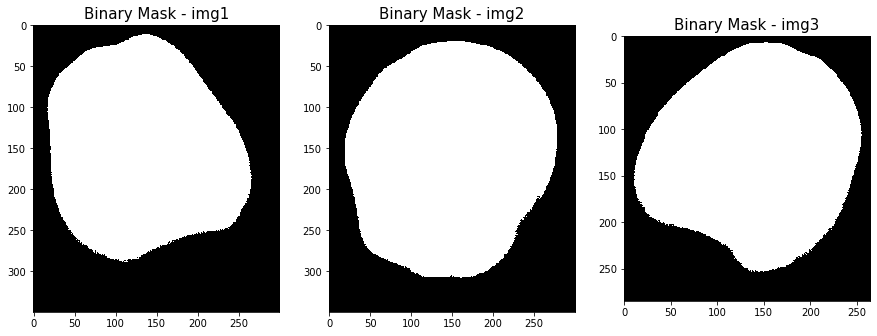

In [17]:
#Plot filled masks
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.title("Binary Mask - img1", fontsize = 15)
plt.imshow(mask1 * 255, cmap='gray', vmin=0, vmax=255)
plt.subplot(1,3,2)
plt.title("Binary Mask - img2", fontsize = 15)
plt.imshow(mask2 * 255, cmap='gray', vmin=0, vmax=255)
plt.subplot(1,3,3)
plt.title("Binary Mask - img3", fontsize = 15)
plt.imshow(mask3 * 255, cmap='gray', vmin=0, vmax=255)
plt.show()

### 2.3 Segmented Images

We apply the binary masks on both the NIR and the colored images: the resulting images present a completely **homogeneous background** and the **unmodified fruit**.

In [19]:
#Create the masks for the colored images
mask1_RGB = cv2.cvtColor(mask1, cv2.COLOR_GRAY2BGR) 
mask2_RGB = cv2.cvtColor(mask2, cv2.COLOR_GRAY2BGR)
mask3_RGB = cv2.cvtColor(mask3, cv2.COLOR_GRAY2BGR) 

#Apply the masks
m_img1_c = img1_c * mask1_RGB
m_img2_c = img2_c * mask2_RGB
m_img3_c = img3_c * mask3_RGB

Img1 = img1 * mask1
Img2 = img2 * mask2
Img3 = img3 * mask3

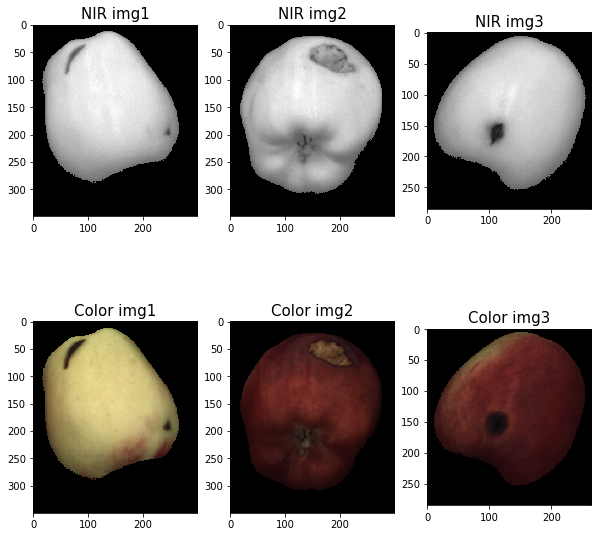

In [20]:
# Plot segmented images
plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(Img1, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.subplot(2,3,2)
plt.imshow(Img2, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img2", fontsize = 15)
plt.subplot(2,3,3)
plt.imshow(Img3, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img3", fontsize = 15)
plt.subplot(2,3,4)
plt.imshow(m_img1_c)
plt.title("Colored img1", fontsize = 15)
plt.subplot(2,3,5)
plt.imshow(m_img2_c)
plt.title("Colored img2", fontsize = 15)
plt.subplot(2,3,6)
plt.imshow(m_img3_c)
plt.title("Colored img3", fontsize = 15)
plt.show()

## 3. Defects Detection

### 3.1 Canny Edge Detector
The imperfections show sharp edges and so we can use an **edge detector** to "draw" their contours. 

There exist several edge detectors and all of them are based on finding the **discontinuities in brightness**. The one we are going to use is named [**Canny Edge Detector**](https://en.wikipedia.org/wiki/Canny_edge_detector) and it is implemented in `OpenCV` in the `Canny` function.

`Canny` function has two parameters (*high-threshold* and *low-threshold*) which determine the **hysteresis process** of thresholding and which have to be carefully tuned.  
There are no universal guidelines to select the best parameter values, so we decided to apply the *Otsu's method* on the masked NIR image to set the *high-threshold* parameter and we set the *low-threshold* equal to half *high-threshold*.

In [11]:
#Otsu's method
h_th1, _ = cv2.threshold(Img1, thresh, maxValue, cv2.THRESH_OTSU)
h_th2, _ = cv2.threshold(Img2, thresh, maxValue, cv2.THRESH_OTSU)
h_th3, _ = cv2.threshold(Img3, thresh, maxValue, cv2.THRESH_OTSU)

print("The high-threshold values are:\n\n {:0.0f} for Img1,\n {:0.0f} for Img2,\n {:0.0f} for Img3."\
      .format(h_th1, h_th2, h_th3))


#Canny's detector
Canny_1 = cv2.Canny(Img1, h_th1 / 2, h_th1)
Canny_2 = cv2.Canny(Img2, h_th2 / 2, h_th2)
Canny_3 = cv2.Canny(Img3, h_th3 / 2, h_th3)

The high-threshold values are:

 99 for Img1,
 89 for Img2,
 90 for Img3.


### 3.2 Erosion
The resulting images show the contours of both the fruit and the imperfections, and we can also notice some *spurious* edges.  
We would like to obtain a binary image with only the fruit defects as foreground, therefore we have to remove the unnecessary parts.  
A very useful tool is the `erode` function of `OpenCV`, which performs the operation of [**erosion**](https://en.wikipedia.org/wiki/Erosion_(morphology)) on the target image.  


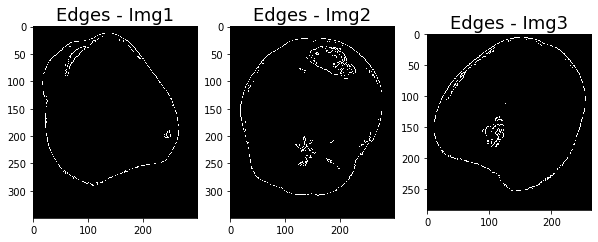

In [12]:
# Plot edges found by Canny's detector
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(Canny_1, cmap = 'gray')
plt.title("Edges - Img1", fontsize = 15)
plt.subplot(1,3,2)
plt.imshow(Canny_2, cmap = 'gray')
plt.title("Edges - Img2", fontsize = 15)
plt.subplot(1,3,3)
plt.imshow(Canny_3, cmap = 'gray')
plt.title("Edges - Img3", fontsize = 15)
plt.show()

The `erode` function takes 3 arguments:
* the original image; 
* the *kernel* (the matrix with which image is convolved);
* the *number of iterations* which will determine the degree of erosion. 

For our purpose, we take as **kernel** a $5 \times 5$ empty matrix and we set at $5$ the **number of iterations**.

We proceed by eroding the original binary mask (the one generated using Otsu's thresholding and filled with the flood-fill approach); then we use the eroded binary mask to extract only the imperfections contours from the image provided by the edge detector.

In the lines below we build the *ad hoc* function `defects` and we generate the three "*defects*" images.

In [13]:
#Erosion

def defects(canny_img, mask, kernel_size = (5,5), n_iter = 1):
    
    #Erosion
    kernel = np.ones(kernel_size, np.uint8) 
    eroded_mask = cv2.erode(mask, kernel, iterations = n_iter)

    #Apply mask
    canny_mask = (np.invert(canny_img)*mask).flatten()
    empty = np.zeros(canny_mask.shape)
    i = 0
    
    for n in eroded_mask.flatten():
        i += 1
        if n :
            if canny_mask[i] == 0:
                empty[i] = 255
    
    return empty.reshape(canny_img.shape)


In [14]:
defects1 = defects(Canny_1, mask1, n_iter=5)
defects2 = defects(Canny_2, mask2, n_iter=5)
defects3 = defects(Canny_3, mask3, n_iter=5)

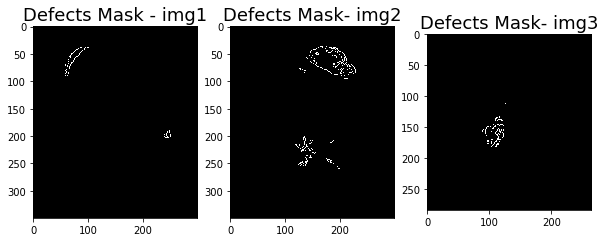

In [15]:
# Plot the defects
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(defects1, cmap = 'gray')
plt.title("Defects Mask - img1", fontsize = 15)
plt.subplot(1,3,2)
plt.imshow(defects2, cmap = 'gray')
plt.title("Defects Mask- img2", fontsize = 15)
plt.subplot(1,3,3)
plt.imshow(defects3, cmap = 'gray')
plt.title("Defects Mask- img3", fontsize = 15)
plt.show()

## 4. Conclusion

We use the "*defects*" images to draw the detected defects both on the NIR and on the colored images.

Looking at the resulting images we can see that, as expected, the pink lines do not perfectly match the real imperfections contours in the colored images: this is due to the parallax effect mentioned at the beginning.

Furthermore, the apple sepals are classified as defects (see *img2*) because they are characterized by a sharp change in intensity and so the edge detector 

In [16]:
def draw_defects_Gray(img, defects):
  
    img_RGB = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    h,w,bpp = img_RGB.shape
    
    for py in range(0,h):
        for px in range(0,w):
            if(defects[py][px]):            
                img_RGB[py][px][0] = 255
                img_RGB[py][px][1] = 0
                img_RGB[py][px][2] = 255
    
    return img_RGB

def draw_defects_RGB(img, defects):

    h,w,bpp = img.shape
    img_copy = img.copy()
    
    for py in range(0,h):
        for px in range(0,w):
            if(defects[py][px]):            
                img_copy[py][px][0] = 255
                img_copy[py][px][1] = 0
                img_copy[py][px][2] = 255
    
    return img_copy

In [17]:
defects_img1 = draw_defects_Gray(img1, defects1)
defects_img2 = draw_defects_Gray(img2, defects2)
defects_img3 = draw_defects_Gray(img3, defects3)

defects_img1_RGB = draw_defects_RGB(img1_c, defects1)
defects_img2_RGB = draw_defects_RGB(img2_c, defects2)
defects_img3_RGB = draw_defects_RGB(img3_c, defects3)

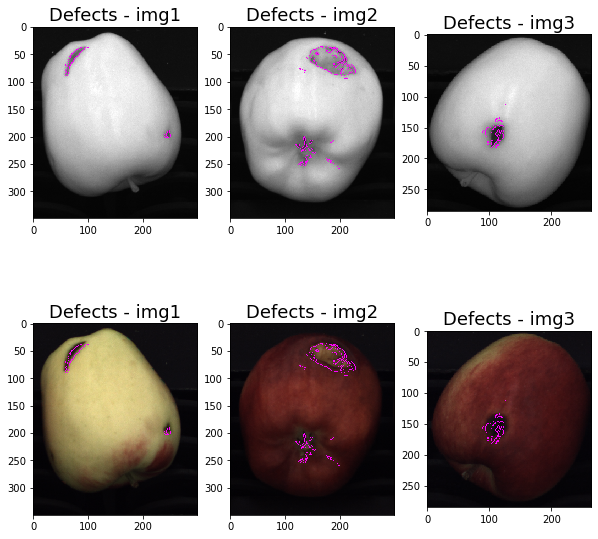

In [18]:
# Plot colored images with defects
plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(defects_img1)
plt.title("Defects - img1", fontsize = 15)
plt.subplot(2,3,2)
plt.imshow(defects_img2)
plt.title("Defects - img2", fontsize = 15)
plt.subplot(2,3,3)
plt.imshow(defects_img3)
plt.title("Defects - img3", fontsize = 15)
plt.subplot(2,3,4)
plt.imshow(defects_img1_RGB)
plt.title("Defects - img1", fontsize = 15)
plt.subplot(2,3,5)
plt.imshow(defects_img2_RGB)
plt.title("Defects - img2", fontsize = 15)
plt.subplot(2,3,6)
plt.imshow(defects_img3_RGB)
plt.title("Defects - img3", fontsize = 15)
plt.show()

--------------------------------------------------

*This work is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US).*

--------------------------------------------------